# Load the data

plan:
    1. aggregate by sum() everything possible
    2. get proportions of health and indicators of dead players
    3. create features for coordinates
    4. generate something for level
    5. dummy variables for game_mode
    6. ....scaling will be done in the training part (CV)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']= 100
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [108]:
# load the data and combine with test data to perform some of the trasformations (without standartization) on all data at the same time
train_df = pd.read_csv('train_features.csv', index_col='match_id_hash')
test_df = pd.read_csv('test_features.csv', index_col='match_id_hash')
idx_split = train_df.shape[0]
full_df = pd.concat([train_df, test_df])
new_features = pd.DataFrame(index=full_df.index)
full_df.head(2)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.0,0,0,0,0,0.0,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.0,0,0,0,0,0.0,0,0,0,0


# Building tree based on location and experience

In [109]:
health = ['r{}_health'.format(x) for x in range(1,6)] +['d{}_health'.format(x) for x in range(1,6)]
max_health = ['r{}_health'.format(x) for x in range(1,6)] +['d{}_health'.format(x) for x in range(1,6)]
x = ['r{}_x'.format(x) for x in range(1,6)] +['d{}_x'.format(x) for x in range(1,6)]
y = ['r{}_y'.format(x) for x in range(1,6)] +['d{}_y'.format(x) for x in range(1,6)]
xp = ['r{}_xp'.format(x) for x in range(1,6)] +['d{}_xp'.format(x) for x in range(1,6)]

train_positions = train_df[health+max_health+x+y+xp]
train_positions.head(2)

,r1_health,r2_health,r3_health,r4_health,r5_health,d1_health,d2_health,d3_health,d4_health,d5_health,...,r1_xp,r2_xp,r3_xp,r4_xp,r5_xp,d1_xp,d2_xp,d3_xp,d4_xp,d5_xp
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,358,636,700,399,422,650,640,720,760,593,...,533,478,130,506,344,780,706,307,421,870
b9c57c450ce74a2af79c9ce96fac144d,1160,1352,710,420,856,700,758,485,567,800,...,3937,3897,2561,4459,2712,3281,2360,3418,2730,1136


In [67]:
target = pd.read_csv(r'C:\Users\Tatiana\Documents\Programming\MLcourse competition\train_targets.csv', index_col = 'match_id_hash')
y = target['radiant_win']
y = y.apply(lambda x: int(x)).values



In [69]:
from sklearn.model_selection import train_test_split

X = train_positions.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=150)


In [129]:
from sklearn.ensemble import RandomForestClassifier

cls = RandomForestClassifier(max_features = 'sqrt', max_depth = 8, n_estimators = 1000, min_samples_leaf=3)
cls.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [130]:
cls.score(X_test,y_test)

0.6789884902965639

In [131]:
from sklearn.metrics import accuracy_score, roc_auc_score
predicted = cls.predict_proba(X_test)[:,1]
roc_auc_score(y_test,predicted)

0.7567104192464178

In [110]:
positions_full = full_df[health+max_health+x+y+xp]
positions = cls.predict_proba(positions_full)[:,1]
new_features['positions'] = positions

# Aggregate features within the team

In [111]:
new_feats = [i.replace("1","")  for i in full_df.columns.values if (i.startswith('r1')==1 or i.startswith('d1')==1)]

In [112]:
rem_feat = ['r_hero_id', 'r_health', 'r_max_health','r_level', 'r_x', 'r_y', 'r_teamfight_participation', 'd_hero_id', 'd_health','d_max_health', 'd_level', 'd_x', 'd_y', 'd_teamfight_participation']
for feat in rem_feat:
    new_feats.remove(feat)

Create a feature that is sum of r1 + ... + r5 for all r features, and same for all d features. Features that do not make sence are removed.

In [113]:
for feature in new_feats:
    feat_names = [(feature[0] + '{}_'.format(i) +feature[2:]) for i in range(1,6)]
    new_features[feature] = full_df.loc[:,feat_names].sum(axis=1)
new_features.columns

Index(['positions', 'r_kills', 'r_deaths', 'r_assists', 'r_denies', 'r_gold',
       'r_lh', 'r_xp', 'r_max_mana', 'r_stuns', 'r_creeps_stacked',
       'r_camps_stacked', 'r_rune_pickups', 'r_firstblood_claimed',
       'r_towers_killed', 'r_roshans_killed', 'r_obs_placed', 'r_sen_placed',
       'd_kills', 'd_deaths', 'd_assists', 'd_denies', 'd_gold', 'd_lh',
       'd_xp', 'd_max_mana', 'd_stuns', 'd_creeps_stacked', 'd_camps_stacked',
       'd_rune_pickups', 'd_firstblood_claimed', 'd_towers_killed',
       'd_roshans_killed', 'd_obs_placed', 'd_sen_placed'],
      dtype='object')

In [114]:
new_features.head()

,positions,r_kills,r_deaths,r_assists,r_denies,r_gold,r_lh,r_xp,r_max_mana,r_stuns,...,d_max_mana,d_stuns,d_creeps_stacked,d_camps_stacked,d_rune_pickups,d_firstblood_claimed,d_towers_killed,d_roshans_killed,d_obs_placed,d_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,0.486581,0,1,0,4,2037,25,1991,1490.68891,0.000000,...,1946.68935,0.299948,0,0,7,1,0,0,1,0
b9c57c450ce74a2af79c9ce96fac144d,0.712940,16,4,14,28,18172,127,17566,2414.68981,42.060296,...,2222.68967,3.532506,3,2,14,1,0,0,5,2
6db558535151ea18ca70a6892197db41,0.614771,0,0,0,0,880,0,0,1670.68912,0.000000,...,1586.68898,0.000000,0,0,1,0,0,0,0,0
46a0ddce8f7ed2a8d9bd5edcbb925682,0.616914,6,2,8,43,13348,131,14663,2474.68982,11.397237,...,2102.68955,13.663390,6,2,11,0,0,0,3,0
b1b35ff97723d9b7ade1c9c3cf48f770,0.543453,2,4,3,0,8079,62,9762,2364.68977,15.262940,...,1958.68937,26.826797,2,1,8,0,0,0,0,0


# Transform health

In [115]:
def are_dead(x):
    ans = 0 
    for el in x:
        if el == 0:
            ans += 1
    return ans

In [116]:
# add number of dead players at the end of the game in each team

d_health = ['d{}_health'.format(i) for i in range(1,6)]
new_features['d_dead'] = full_df[d_health].apply(are_dead, axis = 1)
r_health = ['r{}_health'.format(i) for i in range(1,6)]
new_features['r_dead'] = full_df[r_health].apply(are_dead, axis = 1)

In [117]:
# calculate the proportion of health
percentage_health = 0
for j in range(5):
    max_health = '{}_max_health'.format(d_health[j].split('_')[0])
    health = 'd{}_health'.format(j+1)
    ph = full_df[health]/full_df[max_health]
    percentage_health += 1/5*ph

new_features['d_health_avg'] = percentage_health

percentage_health = 0
for j in range(5):
    max_health = '{}_max_health'.format(r_health[j].split('_')[0])
    health = 'r{}_health'.format(j+1)
    ph = full_df[health]/full_df[max_health]
    percentage_health += 1/5*ph

new_features['r_health_avg'] = percentage_health

In [118]:
new_features.head()

,positions,r_kills,r_deaths,r_assists,r_denies,r_gold,r_lh,r_xp,r_max_mana,r_stuns,...,d_rune_pickups,d_firstblood_claimed,d_towers_killed,d_roshans_killed,d_obs_placed,d_sen_placed,d_dead,r_dead,d_health_avg,r_health_avg
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,0.486581,0,1,0,4,2037,25,1991,1490.68891,0.000000,...,7,1,0,0,1,0,0,0,0.954967,0.715500
b9c57c450ce74a2af79c9ce96fac144d,0.712940,16,4,14,28,18172,127,17566,2414.68981,42.060296,...,14,1,0,0,5,2,0,0,0.764778,0.846735
6db558535151ea18ca70a6892197db41,0.614771,0,0,0,0,880,0,0,1670.68912,0.000000,...,1,0,0,0,0,0,0,0,0.989032,0.989333
46a0ddce8f7ed2a8d9bd5edcbb925682,0.616914,6,2,8,43,13348,131,14663,2474.68982,11.397237,...,11,0,0,0,3,0,0,0,0.869557,0.955818
b1b35ff97723d9b7ade1c9c3cf48f770,0.543453,2,4,3,0,8079,62,9762,2364.68977,15.262940,...,8,0,0,0,0,0,0,0,0.808481,0.735127


This is an unusual form of the graph.

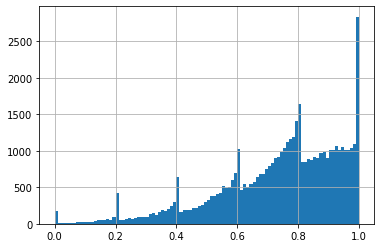

In [49]:
new_features.r_health_avg.hist(bins =100)

# Transform coordinates

In [119]:
def in_opponent_base(x,y,opponent = 'Radiant'):

    '''
returns indicator function of whether the player is in the base of the opponent
opponent = {'Radiant', 'Dire'} - opponent team
    
    '''
#     x = coordinates[0]
#     y = coordinates[1]
    radiant_base_x = 96
    radiant_base_y = 100

    dire_base_x = 156
    dire_base_y = 156

    if opponent == 'Radiant':
        if x <= radiant_base_x and y <= radiant_base_y:
            return 1
        else:
            return 0
    elif opponent == 'Dire':
        if x >= dire_base_x and y >= dire_base_y:
            return 1
        else:
            return 0
    else:
        return NaN

In [120]:
r_x = ['r{}_x'.format(j) for j in range(1,6)]
r_y = ['r{}_y'.format(j) for j in range(1,6)]
d_x = ['d{}_x'.format(j) for j in range(1,6)]
d_y = ['d{}_y'.format(j) for j in range(1,6)]

r_in_d_base = pd.Series(0,index = full_df.index)
d_in_r_base = pd.Series(0,index = full_df.index)

for j in range(5):
    rx = r_x[j]
    ry = r_y[j]
    dx = d_x[j]
    dy = d_y[j]
    r_in_d_base += full_df.loc[:,[rx,ry]].apply(lambda x: in_opponent_base(x = x[rx], y = x[ry], opponent = 'Radiant'), axis = 1)
    d_in_r_base += full_df.loc[:,[dx,dy]].apply(lambda x: in_opponent_base(x = x[dx], y = x[dy], opponent = 'Dire'), axis = 1)

In [121]:
new_features['r_in_d_base'] = r_in_d_base
new_features['d_in_r_base'] = d_in_r_base
new_features.head()

,positions,r_kills,r_deaths,r_assists,r_denies,r_gold,r_lh,r_xp,r_max_mana,r_stuns,...,d_towers_killed,d_roshans_killed,d_obs_placed,d_sen_placed,d_dead,r_dead,d_health_avg,r_health_avg,r_in_d_base,d_in_r_base
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,0.486581,0,1,0,4,2037,25,1991,1490.68891,0.000000,...,0,0,1,0,0,0,0.954967,0.715500,0,0
b9c57c450ce74a2af79c9ce96fac144d,0.712940,16,4,14,28,18172,127,17566,2414.68981,42.060296,...,0,0,5,2,0,0,0.764778,0.846735,1,1
6db558535151ea18ca70a6892197db41,0.614771,0,0,0,0,880,0,0,1670.68912,0.000000,...,0,0,0,0,0,0,0.989032,0.989333,0,2
46a0ddce8f7ed2a8d9bd5edcbb925682,0.616914,6,2,8,43,13348,131,14663,2474.68982,11.397237,...,0,0,3,0,0,0,0.869557,0.955818,0,0
b1b35ff97723d9b7ade1c9c3cf48f770,0.543453,2,4,3,0,8079,62,9762,2364.68977,15.262940,...,0,0,0,0,0,0,0.808481,0.735127,0,0


# Aggreagate the level of players

In [122]:
d_levels = ['d{}_level'.format(j) for j in range(1,6)] 
d_avg_level = full_df.loc[:,d_levels].mean(axis = 1)
d_min_level = full_df.loc[:,d_levels].min(axis = 1)
d_max_level = full_df.loc[:,d_levels].max(axis = 1)
new_features['d_avg_level'] = d_avg_level
new_features['d_min_level'] = d_min_level
new_features['d_max_level'] = d_max_level


r_levels = ['r{}_level'.format(j) for j in range(1,6)] 
r_avg_level = full_df.loc[:,r_levels].mean(axis = 1)
r_min_level = full_df.loc[:,r_levels].min(axis = 1)
r_max_level = full_df.loc[:,r_levels].max(axis = 1)
new_features['r_avg_level'] = r_avg_level
new_features['r_min_level'] = r_min_level
new_features['r_max_level'] = r_max_level

new_features.head(2)

,positions,r_kills,r_deaths,r_assists,r_denies,r_gold,r_lh,r_xp,r_max_mana,r_stuns,...,d_health_avg,r_health_avg,r_in_d_base,d_in_r_base,d_avg_level,d_min_level,d_max_level,r_avg_level,r_min_level,r_max_level
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,0.486581,0,1,0,4,2037,25,1991,1490.68891,0.000000,...,0.954967,0.715500,0,0,2.6,2,3,1.8,1,2
b9c57c450ce74a2af79c9ce96fac144d,0.712940,16,4,14,28,18172,127,17566,2414.68981,42.060296,...,0.764778,0.846735,1,1,6.0,4,7,7.4,6,9


# Team fights participation

In [123]:
# full_df[(full_df.r1_health < full_df.r1_max_health*0.5) & (full_df.r1_health > 0)].r1_teamfight_participation.hist(bins =100)
# full_df[full_df.r1_health == full_df.r1_max_health].r1_teamfight_participation.hist(bins =100)
# full_df[full_df.r1_health == 0].r1_teamfight_participation.hist(bins =100)
r_teamfight = ['r{}_teamfight_participation'.format(j) for j in range(1,6)] 
for col in r_teamfight:
    full_df[full_df[col] >1][col] = 1

d_teamfight = ['d{}_teamfight_participation'.format(j) for j in range(1,6)] 
for col in d_teamfight:
    full_df[full_df[col] >1][col] = 1

# dummy variables encoding

In [99]:
# game_mode = pd.get_dummies(full_df['game_mode'])
# game_mode.columns

In [100]:
# game_mode_col = []
# for name in game_mode.columns:
#     name = 'game_mode_{}'.format(name)
#     game_mode_col.append(name) 
# game_mode.columns = game_mode_col
# game_mode.head(2)

In [101]:
# new_features = new_features.merge(game_mode, how='inner', left_index=True, right_index=True)
# new_features.head(2)

# Adding old features and recording to files

In [102]:
# add other useful features (not team-specific) to the new variables
col_to_drop = []
for i in range(1,6):
    col_to_drop.append('r{}_hero_id'.format(i))
    col_to_drop.append('r{}_x'.format(i))
    col_to_drop.append('r{}_y'.format(i))
    col_to_drop.append('d{}_hero_id'.format(i))
    col_to_drop.append('d{}_x'.format(i))
    col_to_drop.append('d{}_y'.format(i))

new_features = new_features.merge(full_df.drop(columns = col_to_drop), how='inner', left_index=True, right_index=True)
new_features.head(2)

,r_kills,r_deaths,r_assists,r_denies,r_gold,r_lh,r_xp,r_max_mana,r_stuns,r_creeps_stacked,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,0,1,0,4,2037,25,1991,1490.68891,0.000000,0,...,0.0,0,0,0,0,0.0,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,16,4,14,28,18172,127,17566,2414.68981,42.060296,2,...,0.0,0,0,0,0,0.0,0,0,0,0


In [124]:
## creating smaller datset
new_features = new_features.merge(full_df[['chat_len','game_time','game_mode','lobby_type']], how='inner', left_index=True, right_index=True)
new_features.head(2)

,positions,r_kills,r_deaths,r_assists,r_denies,r_gold,r_lh,r_xp,r_max_mana,r_stuns,...,d_avg_level,d_min_level,d_max_level,r_avg_level,r_min_level,r_max_level,chat_len,game_time,game_mode,lobby_type
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,0.486581,0,1,0,4,2037,25,1991,1490.68891,0.000000,...,2.6,2,3,1.8,1,2,11,155,22,7
b9c57c450ce74a2af79c9ce96fac144d,0.712940,16,4,14,28,18172,127,17566,2414.68981,42.060296,...,6.0,4,7,7.4,6,9,10,658,4,0


In [125]:
log_tags = ['_kills', '_deaths', '_assists', '_gold', '_lh', '_xp', '_max_mana', '_creeps_stacked', 
               '_camps_stacked','_rune_pickups', '_sen_placed']
# prefix = ['r{}'.format(x) for x in range(1,6)]
# prefix += ['d{}'.format(x) for x in range(1,6)]
prefix = ['r', 'd']
col_for_log = []
for tag in log_tags:
    for p in prefix:
        col_for_log.append(p+tag)
col_for_log += ['chat_len', 'game_time']

In [126]:
import math

for col in col_for_log:
    new_log_index = 'log_{}'.format(col)
#     print(new_features[col].min())
    new_log_col = new_features[col].apply(lambda x: math.log(x+1))
    new_features[new_log_index] = new_log_col
    
new_features.head()

,positions,r_kills,r_deaths,r_assists,r_denies,r_gold,r_lh,r_xp,r_max_mana,r_stuns,...,log_r_creeps_stacked,log_d_creeps_stacked,log_r_camps_stacked,log_d_camps_stacked,log_r_rune_pickups,log_d_rune_pickups,log_r_sen_placed,log_d_sen_placed,log_chat_len,log_game_time
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,0.486581,0,1,0,4,2037,25,1991,1490.68891,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.098612,2.079442,0.000000,0.000000,2.484907,5.049856
b9c57c450ce74a2af79c9ce96fac144d,0.712940,16,4,14,28,18172,127,17566,2414.68981,42.060296,...,1.098612,1.386294,0.693147,1.098612,2.639057,2.708050,1.386294,1.098612,2.397895,6.490724
6db558535151ea18ca70a6892197db41,0.614771,0,0,0,0,880,0,0,1670.68912,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.386294,0.693147,0.000000,0.000000,0.000000,3.091042
46a0ddce8f7ed2a8d9bd5edcbb925682,0.616914,6,2,8,43,13348,131,14663,2474.68982,11.397237,...,0.000000,1.945910,0.000000,1.098612,2.639057,2.484907,0.000000,0.000000,1.609438,6.357842
b1b35ff97723d9b7ade1c9c3cf48f770,0.543453,2,4,3,0,8079,62,9762,2364.68977,15.262940,...,0.000000,1.098612,0.000000,0.693147,2.484907,2.197225,0.000000,0.000000,1.386294,6.118097


In [127]:
train = new_features.iloc[:idx_split, :]
test = new_features.iloc[idx_split:, :]

In [128]:
train.to_csv('new_feat_train.csv')
test.to_csv('new_feat_test.csv')

In [38]:
test.shape

(10000, 72)